In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

In [2]:
from pathlib import Path
from collections import namedtuple, deque

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
max_tile_size = 512
bs = 16

In [5]:
path = Path("dataset_segmentation/")
path_lbl = path / "labels"
path_img = path / "images"

In [6]:
def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [7]:
ImageTile = namedtuple('ImageTile', 'path idx rows cols')


def calc_n_tiles(size, tile_max_size):
    x, y = size
    n_cols = x % (x // tile_max_size + 1)
    n_rows = y % (y // tile_max_size + 1)
    x_size_tile, y_size_tile = x//n_cols, y//n_rows
    # x_diff is due to int division when calculanting tiles, in pixel is less than n_rows
    x_diff = x - (x_size_tile*n_cols)
    y_diff = y - (y_size_tile*n_rows)
    return n_rows, n_cols, (x_size_tile,y_size_tile), x_diff, y_diff

def get_label(path):
    return path_lbl / path.name

def get_labels_tiles(fn):
    path, *tile = fn
    path = get_label(path)
    return ImageTile(path, *tile)


def get_tiles(images: PathOrStr, rows: int, cols: int) -> Collection[ImageTile]:
    images_tiles = []
    for img in images:
        for i in range(rows * cols):
            images_tiles.append(ImageTile(img, i, rows, cols))
    return images_tiles

def open_image_cached(path, mask=False, keys=deque([], 5), data=deque([], 5), **kwargs):
    # caches the last outputs of open image using a fixed lenght deque
    # if mask is True open a masks instead of an image
    if path in keys:
        idx = keys.index(path)
        img = data[idx]
    else:
        img = open_image(path, **kwargs) if not mask else open_mask(path, **kwargs)
        keys.append(path)
        data.append(img)
    return img
        
def open_image_tile(img_t: ImageTile, mask=False, **kwargs) -> Image:
    """given and ImageTile it returns and Image with the tile,
    set mask to True for masks, indexes increase going down on columns from the top left tile, till the bottom right tile"""
    # looks like it is rather slow, maybe increase performance by caching latest open images? 
    path, idx, rows, cols = img_t
    # swap rows with columns due to pytorch image 'style' (height x width)
    rows, cols = cols, rows
    #caches the last    
    img = open_image_cached(path, mask=mask, **kwargs)
    row = idx // cols
    col = idx % cols
    tile_x = img.size[0] // cols
    tile_y = img.size[1] // rows
    return Image(img.data[:, col * tile_x:(col + 1) * tile_x, row * tile_y:(row + 1) * tile_y])


class SegmentationTileLabelList(SegmentationLabelList):

    def open(self, fn: ImageTile):
        return open_image_tile(fn, div=True, mask=True)


class SegmentationTileItemList(ImageList):
    _label_cls, _square_show_res = SegmentationTileLabelList, False

    # accepts as inputs a tuple of TileInfo and PathOrStr
    def open(self, fn: ImageTile) -> Image:
        return open_image_tile(fn, convert_mode=self.convert_mode, after_open=self.after_open)

    @classmethod
    def from_folder(cls, path: PathOrStr = '.', rows=1, cols=1, extensions: Collection[str] = None, **kwargs) -> ItemList:
        """Create an `ItemList` in `path` from the filenames that have a suffix in `extensions`.
        `recurse` determines if we search subfolders."""
        files = get_files(path, extensions, recurse=True)
        files_tiled = get_tiles(files, rows, cols)
        return SegmentationTileItemList(files_tiled, **kwargs)

In [8]:
#calc number tiles with hardcoded sizes
img_size = (2219, 3149)
rows, cols, tile_size, x_diff, y_diff = calc_n_tiles(img_size, max_tile_size)
print(tile_size)
print(rows, cols)
print(x_diff,y_diff)

(554, 524)
6 4
3 5


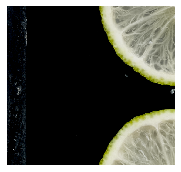

In [9]:
st = SegmentationTileItemList.from_folder(path_img, rows, cols)
i = st[2]
st.split_by_rand_pct()
show_image(i)

In [22]:
i.shape

torch.Size([3, 524, 554])

TODO add tranforms and debug get_transforms() issues

In [10]:
codes = ['background','fruit']
data = (SegmentationTileItemList
    .from_folder(path_img, rows, cols)
    .split_by_rand_pct()
    .label_from_func(get_labels_tiles, classes=codes)
    .transform([])
    .databunch(bs=bs)
    .normalize(imagenet_stats))


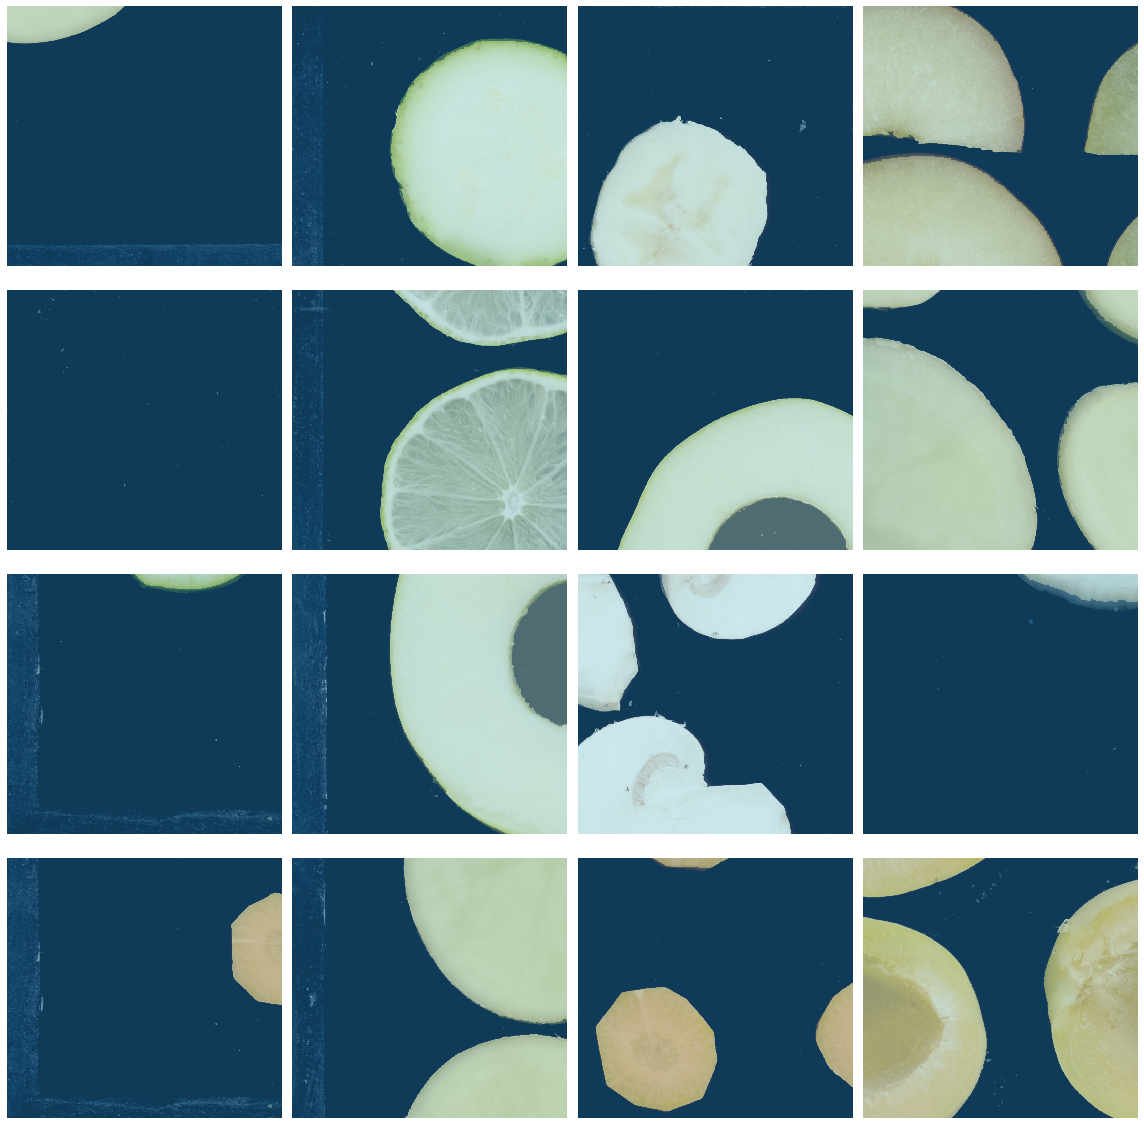

In [26]:
data.show_batch()

In [11]:
learn = unet_learner(data, models.resnet34, metrics=seg_accuracy)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.017942,0.023744,0.992472,38:18


In [11]:
inf_learn = unet_learner(data, models.resnet34, metrics=seg_accuracy).load("1run_test1")

In [14]:
def predict_mask(img_path):
    #uses all the global variables that are output of calc_n_tiles(), maybe refactor
    i = 0
    end_mask = None #sentinel value for first iteration
    for col in range(cols):
        col_mask = None
        for row in range(rows):
            img_tile = open_image_tile(ImageTile(img_path, idx=i, rows=rows, cols=cols))
            mask_tile, _, _ = inf_learn.predict(img_tile)
            mask_tile = mask_tile.data.permute(1,2,0) #convert to numpy style it is the way to think about the image
            col_mask = np.vstack((col_mask, mask_tile)) if col_mask is not None else mask_tile
            i += 1
        end_mask = np.hstack((end_mask, col_mask)) if end_mask is not None else col_mask
    #add padding to make pred_mask size the same of the original image
    pred_mask = torch.zeros((*img_size, 1), dtype=torch.long) # iniziatlize mask with correct size with all black
    pred_mask[:-x_diff,:-y_diff, :] = torch.tensor(end_mask).permute(1,0,2) #copy mask on the all black background
    return Image(pred_mask.permute(2,1,0)) #convert back to pytorch image style

In [94]:
im = predict_mask(path_img / "albicocche1.png")

In [12]:
def seg_test_image_tile(img: ImageTile, real_mask: ImageTile):
    pred_mask, _, _ = inf_learn.predict(open_image_tile(img))
    real_mask = open_image_tile(real_mask, div=True, mask=True)
    wrong = np.count_nonzero(pred_mask.data != real_mask.data)    
    intersection = np.logical_and(real_mask.data, pred_mask.data)
    union = np.logical_or(real_mask.data, pred_mask.data)
    iou_score = torch.div(torch.sum(intersection),torch.sum(union).float())
    
    return iou_score, wrong

In [13]:
#warning img_size: number of pixels
def seg_benchmark_tile(path_img):
    "benchmarks the full dataset in path_img analysing the single tiles"
    imgs = get_image_files(path_img)
    imgs = get_tiles(imgs, rows, cols)
    masks = [get_labels_tiles(f) for f in imgs]
    wrongs = torch.empty(len(imgs), dtype=torch.float32)
    iou_scores = torch.empty(len(imgs), dtype=torch.float32)
    for i, img, mask in zip(range(len(imgs)), imgs, masks):
        iou_score, wrong = seg_test_image_tile(img, mask)
        wrongs[i] = wrong
        iou_scores[i] = iou_score
                            
    wrong_perc = torch.mean(wrongs) * 100 / 
    print(f"perc of wrong pixels: {wrong_perc}%")
    print(f"mean accuracy: {100-wrong_perc}%")
    print(f"max wrong per image: {torch.max(wrongs)} over {img_size} pixels")
    print(f"mean IoU: {torch.mean(iou_scores)}")
    print(f"min IoU: {torch.min(iou_scores)}")

In [32]:
seg_bench_test_tile(4,6, tile_size[0]*tile_size[1])

perc of wrong pixels: 0.7767105102539062%
mean accuracy: 99.2232894897461%
max wrong per image: 38950.0 over 290296 pixels
mean IoU: nan
min IoU: nan


In [108]:
def seg_test_full_image(img_p: PathOrStr):
    pred_mask = predict_mask(img_p)
    real_mask = open_mask(get_label(img_p), div=True) 
    pred_mask, real_mask = pred_mask.data, real_mask.data
    wrong = np.count_nonzero(pred_mask != real_mask)
    
    intersection = np.logical_and(real_mask, pred_mask)
    union = np.logical_or(real_mask, pred_mask)
    iou_score = torch.div(torch.sum(intersection),torch.sum(union).float())
    
    return iou_score, wrong

In [109]:
seg_test_full_image(path_img / "albicocche1.png")

(tensor(0.9972), 10064)

In [ ]:
def plot_pixel_difference_tile(img, real_mask, figsize=(20,20)):
    img = open_image_tile(img)
    pred_mask, _, _ = inf_learn.predict(img)
    real_mask = open_image_tile(real_mask, mask=True, div=True)
    real_mask = image2np(real_mask.data)
    pred_mask = image2np(pred_mask.data)
    img = image2np(img.data)
    diff = pred_mask != real_mask
    img[diff==1] = (1, 0 ,0) # 0000FF is blue FF0000 is red
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
img_path_t = path_img / "albicocche1.png"
img_t = ImageTile(path_img / "albicocche1.png", 0, 4, 6)
mask_t = get_labels_tiles(img_t)
plot_pixel_difference_tile(img_t, mask_t)

In [12]:
def plot_pixel_difference_full(img_p, mask_p, figsize=(20,20)):
    img = open_image(img_p)
    pred_mask = predict_mask(img_p)
    real_mask = open_mask(mask_p, div=True)
    real_mask = image2np(real_mask.data)
    pred_mask = image2np(pred_mask.data)
    img = image2np(img.data)
    diff = pred_mask != real_mask
#     breakpoint()
    img[diff==1] = (1, 0 ,0) # 0000FF is blue FF0000 is red
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)

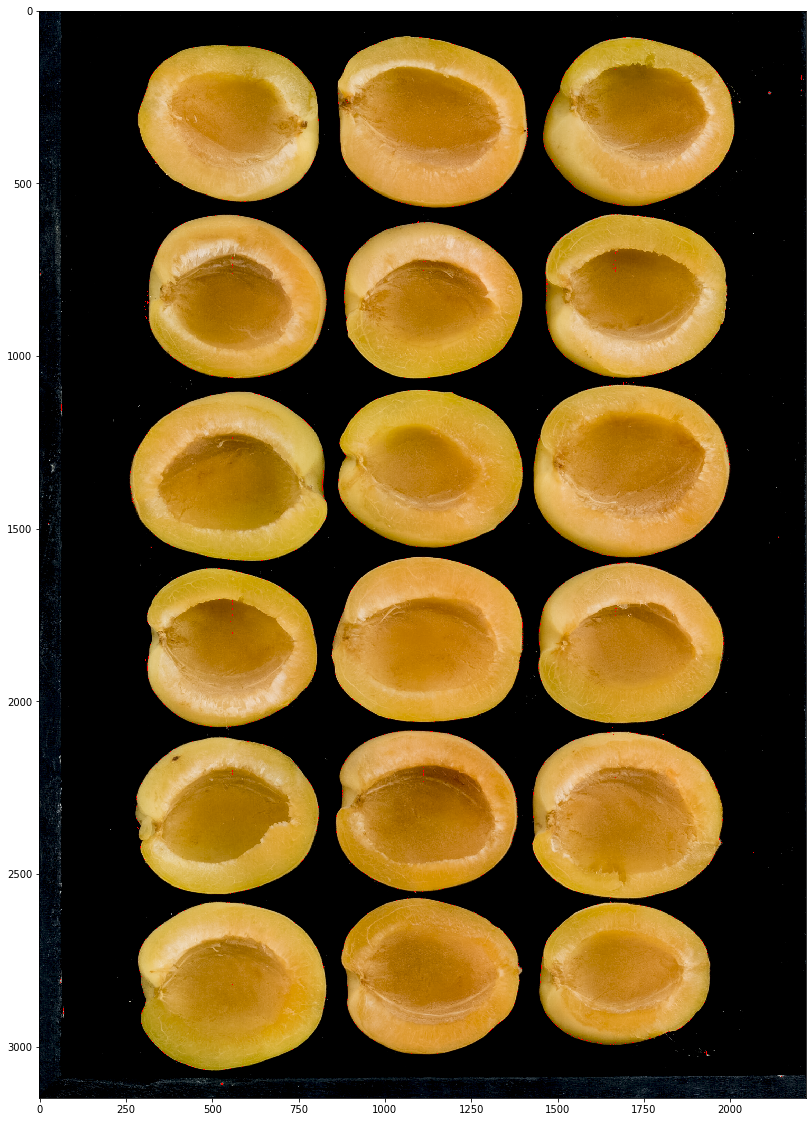

In [15]:
img_p = path_img / "albicocche1.png"
mask_p = get_label(img_p)
plot_pixel_difference_full(img_p, mask_p)